<h1><center>Project Machine Learning - SYM</center></h1>
<h3><center>Michael Trushkin ( 323363838 ) and Maayan furer ( 209365634 ).</center></h3>
<h4><center><strong>Loading imports</strong></center></h4>

In [161]:
import importlib
import numpy as np
import game
importlib.reload(game)
from game import ColorableCliqueGame
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
import gameEnvF
importlib.reload(gameEnvF)
from gameEnvF import draw, triangle_huristic, alphabetaMaxDepth, alphabetaMove, random_move, getPsuedoLegalStates, getLegalStatesAndTag, triangleP0_huristic, triangleSQR_huristic, distinct_cherry_counter, numpy_distinct_cherry_counter
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

models = {}

<h4><strong>Preview of game state</strong></h4>

<strong>Rules:</strong> </br>
There is a graph K6, that start blank all edges are white. </br>
each turn a player colors one edge in it own color. </br>
the player that creates a monochromatic triangle in its own color first loses.

<strong>Some Facts </strong></br>
In many games such as this there is the problem where the first player to move loses. </br>
and in this game its also the case, its possible to find a strategy such that the blue player, second player wins 100% of the times. </br>
we also notice in later stages that its considerably harder to win as red player, even when the red player can look "deeper" into the future. </br>
Maybe that just means that our huristic function is actually pretty good.

<strong>About the Vector:</strong> </br>
The Values 1-15, reprecent the color of the coresponding edge, first value is probably the color of (0<->1).</br>
The last value in the vector reprecent the next player to move.

Game state ( 0 ): [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1]
Game state ( 1 ): [ 0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  1]
Game state ( 2 ): [ 0  0  0  0  0  1  0 -1  0  0  0  0  0  0  0 -1]
Game state ( 3 ): [ 0  0  0  0  0  1  0 -1  0 -1  0  0  0  0  0  1]
Game state ( 4 ): [ 0  0  0  0  0  1  0 -1  0 -1  0  0  0  0  1 -1]
Game state ( 5 ): [ 0  0  0  0  0  1  0 -1 -1 -1  0  0  0  0  1  1]


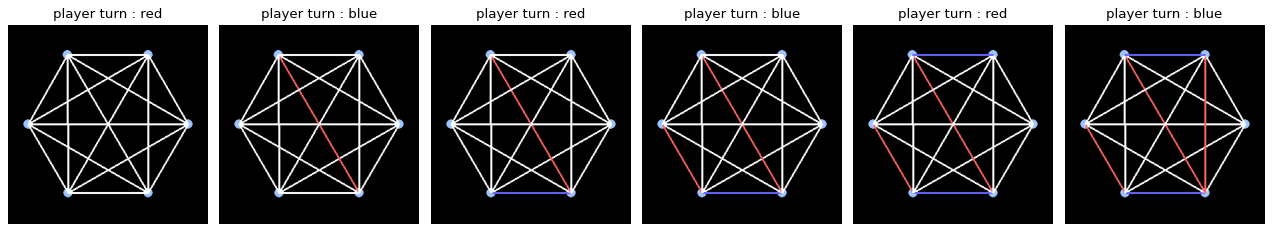

In [162]:
colors = [(255,100,100), (100,100,255)]
env = ColorableCliqueGame(300,300,6,colors)
figure(figsize=(16, 6), dpi=80)
moves = 6
for i in range(moves):
    plt.subplot(1,moves,i+1)
    axs = plt.gca()
    axs.set_axis_off()
    draw(env, False)
    print("Game state (", i ,"):" ,env.state1D())
    player = "red"
    if env.player == 1:
        player = "blue"
    axs.set_title("player turn : " + player)
    random_move(env)
env.undo()
plt.tight_layout()

<h4><strong>Loading the data</strong></h4>

As this game uses a K6, it has 15 distinct edge that each can be colored in 3 colors, white, blue or red.<br>
hence there are 3^15 possible game states, but from there there are a lot of unreachable states i.e, the possible states are where, <br>
the number of red edges to blue edges is equal or red has by 1 more (as red plays first).

For thus we made functions above that iterate over all possible legal states, then we made an aproximation function that yields, <br>
how "likely", red/blue to win, where value > 0, means that the huristic function thinks that red is more likely to win, and negative value means blue is more likely.

In [163]:
filename = 'data\K6D3n.npz'
with open(filename, 'rb') as f:
    a = np.load(f, allow_pickle=True)['data']

X : np.ndarray = a[:, 0]
Y : np.ndarray = a[:, 1]
Y = Y.astype(np.float32)
X = np.array(list(X))

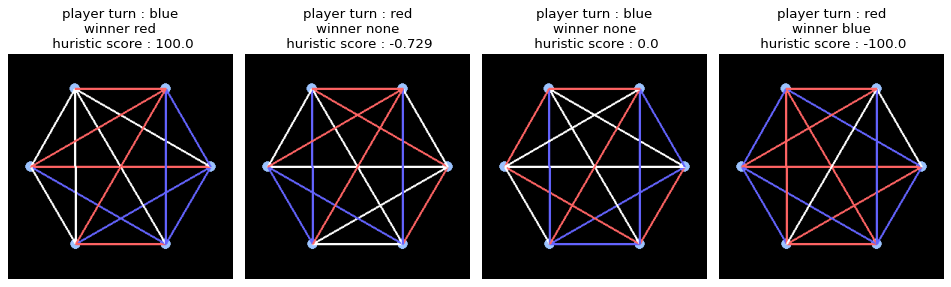

In [164]:
indexes = [45001, 60000, 250000, 170001]
figure(figsize=(12, 6), dpi=80)
i = 1
for index in indexes:
    plt.subplot(1,len(indexes),i)
    axs = plt.gca()
    axs.set_axis_off()
    player = "red"
    if X[index][-1] == -1:
        player = "blue"

    colors = [(255,100,100), (100,100,255)]
    env = ColorableCliqueGame(300,300,6, colors)
    env.loadfrom1D(X[index])
    draw(env, False)
    winner = "none"
    if env.winner == 0:
        winner = "red"
    elif env.winner == 1:
        winner = "blue"
    axs.set_title("player turn : " + player + "\nwinner " + winner +"\n huristic score : " + str(Y[index]))
    i += 1
plt.tight_layout()

<h4><strong>About the huristic function</strong></h4>
The huristic function we made is countring the distinct monochromatic crerry's in the graph, </br>
that is the number of cherries such that the remaining edge is not colored yet, where the white edges are distinct. </br>
basically if we counted 5 distinct cherries for player RED, that means that there is 5 edges that he cannot color in red, otherwise this will create a red triangle.

<h4><strong>MinMax</strong></h4>
To further improve the huristic's we use the MinMax algorithm, for verious depths, out huristic then outputs red_cherries - blue_cherries. </br>
Our dataset consist of prediction of MinMax at depth 3. 

In the plots below we see that MinMax of depth 5, actually have a solid calculation that means that for the examples below for depth 5 we can tell with player will win, if played optimally.

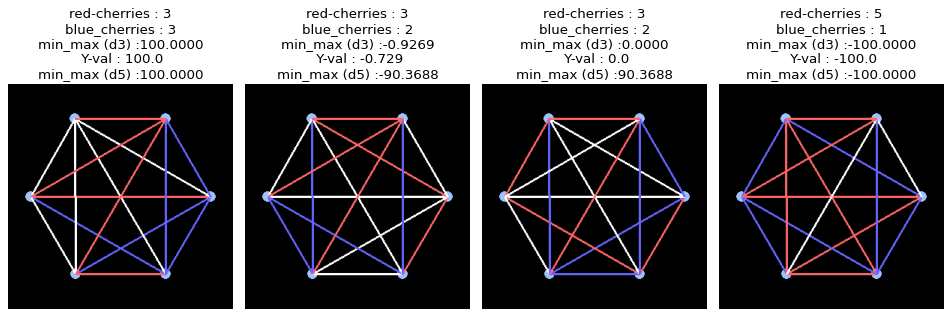

In [165]:
indexes = [45001, 60000, 250000, 170001]
figure(figsize=(12, 6), dpi=80)
i = 1
for index in indexes:
    plt.subplot(1,len(indexes),i)
    axs = plt.gca()
    axs.set_axis_off()
    player = "red"
    if X[index][-1] == -1:
        player = "blue"

    colors = [(255,100,100), (100,100,255)]
    env = ColorableCliqueGame(300,300,6, colors)
    env.loadfrom1D(X[index])
    draw(env, False)
    winner = "none"
    if env.winner == 0:
        winner = "red"
    elif env.winner == 1:
        winner = "blue"
    
    red_cherries, blue_cherries = distinct_cherry_counter(env)
    d3score = "{:.4f}".format(alphabetaMaxDepth(env, -9999, 9999, 3, triangle_huristic))
    d5score = "{:.4f}".format(alphabetaMaxDepth(env, -9999, 9999, 5, triangle_huristic))
    
    axs.set_title("red-cherries : " + str(red_cherries) + "\nblue_cherries : " + str(blue_cherries) + "\nmin_max (d3) :" + d3score + "\n Y-val : " + str(Y[index]) + "\nmin_max (d5) :" + d5score)
    i += 1
plt.tight_layout()

<h3><strong>Our Goal.</strong></h3>

We wish to train a model that will infact learn our huristic function prediction in a much better way, that is, our model will
need to predict how good/bad each gamestate for each corresponding player, but without actually running the min/max algorithm.

In fact we can in the end test our model vs the huristic too check if our new huristic is better at the original cherry counter huristics.

<h4><strong>Creating test and train data.</strong></h4>
First Lets limit the Y values to be between -1 and 1.

In [166]:
Yn = Y / Y.max()
print(X.shape)
print("Min value:", Yn.min())
print("Max value:", Yn.max())
print("Mean value:", Yn.mean())
print("Variance:", Yn.var())

(2575131, 16)
Min value: -1.0
Max value: 1.0
Mean value: -0.13704717
Variance: 0.51669466


We exclude the data, where either player won, as in that case we can easily detect that the player won/lost. </br>
Our initial goal was to train the model, and then try to use MinMax with the trained model to see how well it performes. </br>
Hence the MinMax would infact detect win/loss situations regardless of the model predictions.

In our data the Win\loss examples might actually confuse the model.
(in fact after testing we saw that this is the case).

In [167]:
It = abs(Yn) == 1
X1 = X[It]
Y1 = Yn[It]
print(X1.shape)

(1226700, 16)


<h4><strong>Creating test and train data.</strong></h4>

In [168]:
X_train,X_test,y_train,y_test =train_test_split(X1,Y1 , test_size=0.20, random_state=42,shuffle=True)

<h4><strong>Running Linear regression.</strong></h4>

In [169]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
lin_pred_test = lin_reg.predict(X_test)
lin_pred_train = lin_reg.predict(X_train)
r2_test = r2_score(y_test,lin_pred_test)
r2_train = r2_score(y_train,lin_pred_train)
print('R squared of Linear Regression for Test Date :', r2_test)
print('R squared of Linear Regression for Train Date :', r2_train)

target_predicted = lin_reg.predict(X_test)
print("y test mean: ",y_test.mean(), " y test var: ",y_test.var())
print("Linear Regression MSE:",mean_squared_error(y_test, target_predicted))


R squared of Linear Regression for Test Date : 0.060775862050442386
R squared of Linear Regression for Train Date : 0.06158920937526802
y test mean:  -0.23570555  y test var:  0.9444428
Linear Regression MSE: 0.8870436267417392


<h3>Observations - Linear regression fails completly.</h3>
We can see that the test-set has a variance of 0.51, hence a "dummy" classifier that picks a tag uniformly at random would have Variance of 0.51,</br>
that is the MSE of a dummy classifier should be appriximatly 0.51.

Where the Linear regression model got a score of 0.50, with suggest that Linear regression does not perform well at all. </br>
Also the R2, score is very low with about 2% of the data being "learned".

<h4>It was to be expected</h4>
As discussed above the huristic function "counts" the number of distinct cherries in the K6 graph, and that problem is not really linear by nature, </br>
combining the fact that we also use the MinMax algorithm to further complicate the huristics its to be expected that Linear regression would fail.

In [170]:
def score_model(_model, X_train, y_train, X_test, y_test, model_name = "Model"):
    pred_test = _model.predict(X_test)
    pred_train = _model.predict(X_train)
    r2_test = r2_score(y_test, pred_test)
    r2_train = r2_score(y_train, pred_train)
    print('R squared of', model_name, 'for Test Date :', r2_test)
    print('R squared of', model_name,'for Train Date :', r2_train)

    print("y test mean: ",y_test.mean(), " y test var: ",y_test.var())
    print(model_name ,"MSE:",mean_squared_error(y_test, pred_test))

<h4><strong> Final Attempt - Linear regression </strong></h4>
Lasly before we try other models we want to try to add a few new features, the features would count the number of cherries,
Notice that we do not run MinMax with depth 3, we simply count the current number of cherries, as extra leverage to the model.

This Observation should help the model to learn when some player is really "worse" then the other.

<h4> Why add cherry count? </h4>

We add the cherry count observation because even as a human player we can count the number of "bad" edges. </br>
So it makes sense too help our model by providing that observation.

In [171]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
# The ColumnsSelector class inherits from the sklearn.base classes 
# (BaseEstimator, TransformerMixin). This makes it compatible with 
# scikit-learn’s Pipelines
class AddCherryCount(BaseEstimator, TransformerMixin):
    # initializer 
    def __init__(self):
        # save the features list internally in the class
        pass
        
    def fit(self, X, y = None):
        return self
    def transform(self, X, y = None):
        Xn = np.apply_along_axis(numpy_distinct_cherry_counter, 1, X)
        Xn = np.concatenate((X, Xn), axis=1)
        # return the dataframe with the specified features
        return Xn

In [172]:
# This functions is quite expensive in time
test = AddCherryCount()
test.transform(X_train[::25])

array([[ 1, -1, -1, ...,  1,  5,  2],
       [ 0, -1,  0, ..., -1,  3,  5],
       [ 0,  1,  0, ...,  1,  3,  4],
       ...,
       [ 1,  0, -1, ...,  1,  2,  4],
       [ 0,  0,  0, ..., -1,  5,  2],
       [ 0, -1,  1, ..., -1,  4,  1]], dtype=int64)

In [173]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('lreg', LinearRegression())])
pipe.fit(X_train, y_train)

score_model(pipe, X_train, y_train, X_test, y_test, "RegCherry")

R squared of RegCherry for Test Date : 0.7838366119662784
R squared of RegCherry for Train Date : 0.782978484185179
y test mean:  -0.23570555  y test var:  0.9444428
RegCherry MSE: 0.20415399045090585


<h3>Observations - Considerable improvment.</h3>

As expected adding the red/blue cherry features indeed increased the performance of the linear regression model, </br>
for the last step lets try normalizing after adding the features.

This improvement is far better then we have expected.

In [174]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('lreg', LinearRegression())])
pipe.fit(X_train, y_train)

score_model(pipe, X_train, y_train, X_test, y_test, "RegCherry")

models["preg"] = pipe

R squared of RegCherry for Test Date : 0.7838366678510068
R squared of RegCherry for Train Date : 0.7829785251463097
y test mean:  -0.23570555  y test var:  0.9444428
RegCherry MSE: 0.2041539376709674


<h4><strong>Adaboost</strong></h4>

We use only fraction of the data as adaboost simply "crashes" when used on the full dataset

In [175]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train[::30], y_train[::30])

score_model(regr, X_train, y_train, X_test, y_test, "Adaboost")

R squared of Adaboost for Test Date : 0.06171426950609005
R squared of Adaboost for Train Date : 0.0627658108717728
y test mean:  -0.23570555  y test var:  0.9444428
Adaboost MSE: 0.8861573544248496


Very poor performance.

In [176]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('Adaboost', AdaBoostRegressor(random_state=0, n_estimators=200))])
pipe.fit(X_train[::30], y_train[::30])

score_model(pipe, X_train, y_train, X_test, y_test, "Adaboost cherry")

models["pada"] = pipe

R squared of Adaboost cherry for Test Date : 0.8976902300651701
R squared of Adaboost cherry for Train Date : 0.8972031903760475
y test mean:  -0.23570555  y test var:  0.9444428
Adaboost cherry MSE: 0.09662574214950433


Adaboost performance with the added cherries is much better.

<h4><strong>Decision tree.</strong></h4>
We expect a much better result with decision trees, as part of countring cherries is a lot of if/then statements.

<strong>Notice</strong></br>
As out dataset is quite big the kernel of python fails to run the fit function so we need to take fraction of the dataset, and not all of the dataset.

In [177]:
model = DecisionTreeRegressor()
model.fit(X_train[::30],y_train[::30])

score_model(model, X_train, y_train, X_test, y_test, "Decision Tree")

R squared of Decision Tree for Test Date : 0.34150343311990905
R squared of Decision Tree for Train Date : 0.36226350089020565
y test mean:  -0.23570555  y test var:  0.9444428
Decision Tree MSE: 0.6219124480313035


<h3>Observations - Not good, but better then Linear regression.</h3>
Decision tree performs better then the Raw, Linear regression, as to be expected.

<strong>Adding cherries:</strong></br>

In [178]:
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('Decision Tree', DecisionTreeRegressor())])
pipe.fit(X_train[::30], y_train[::30])

score_model(pipe, X_train, y_train, X_test, y_test, "Decision Tree Cherry")

models["ptree"] = pipe

R squared of Decision Tree Cherry for Test Date : 0.8978376541408736
R squared of Decision Tree Cherry for Train Date : 0.8991664040913407
y test mean:  -0.23570555  y test var:  0.9444428
Decision Tree Cherry MSE: 0.09648650851879025


<h3>Observations - Considerable improvment.</h3>

As expected adding the red/blue cherry features indeed increased the performance.</br>
Somehow Linear regression with cherries works even better, we assume that probably due to the fact that red_cherries - blue_cherries.
Is a good estimator to who should win, except for a fraction of positions.

<h4><strong> Random Forest </strong></h4>
Random forest is a model that just utalizes a lot of decisions trees, its similar to adaboost but where each model is in fact a decision tree.</br>
Hence its the Ideal candidate for our next model.</br>
For the same reason we cant train the RandomForest on all the data at once so we will add estimators to the decision tree and fit it in chunks

In [179]:
rf = RandomForestRegressor(n_estimators=10, warm_start=True, n_jobs=-1)
skip = 29
for i in range(skip):
    rf.fit(X_train[i::skip], y_train[i::skip])
    rf.n_estimators += 3

In [180]:
score_model(rf, X_train, y_train, X_test, y_test, "Random Forest")

models["rf"] = rf

R squared of Random Forest for Test Date : 0.8692953596635159
R squared of Random Forest for Train Date : 0.8747705415191033
y test mean:  -0.23570555  y test var:  0.9444428
Random Forest MSE: 0.12344307765467186


<h3>Observations</h3>
We can see that the random-forest model is considerably better then both Linear-regression and Decision tree, even without the cherry counting.

<strong>Adding cherries</strong>

In [181]:
rfp = RandomForestRegressor(n_estimators=10, warm_start=True, n_jobs=-1)
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('Random forest', rfp)])
skip = 29
for i in range(skip):
    pipe.fit(X_train[i::skip], y_train[i::skip])
    rfp.n_estimators += 3

In [182]:
score_model(pipe, X_train, y_train, X_test, y_test, "Random Forest")

models["prf"] = pipe

R squared of Random Forest for Test Date : 0.9546316560253341
R squared of Random Forest for Train Date : 0.9561177611073294
y test mean:  -0.23570555  y test var:  0.9444428
Random Forest MSE: 0.04284781316035105


<strong>Observations</strong></br>
As we can see we got even better results then before.


<h4><strong>KNN</strong></h4>
The issue with KNN is due to the sheer size of the data, it takes a very long time to make a prediction.

In [183]:
from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=41)
model.fit(X_train, y_train)

score_model(model, X_train[::1000], y_train[::1000], X_test[::1000], y_test[::1000], "KNN")

models["knn"] = model

R squared of KNN for Test Date : 0.9869079680430698
R squared of KNN for Train Date : 0.9888891529416515
y test mean:  -0.30081302  y test var:  0.9095113
KNN MSE: 0.011907353


In [184]:
from sklearn.neighbors import KNeighborsRegressor
pipe = Pipeline([('cherrys', AddCherryCount()), ('scaler', StandardScaler()), ('KNN', KNeighborsRegressor(n_neighbors=41))])
pipe.fit(X_train, y_train)

score_model(pipe, X_train[::1000], y_train[::1000], X_test[::1000], y_test[::1000], "KNN")

models["pknn"] = pipe

R squared of KNN for Test Date : 0.9970008505265251
R squared of KNN for Train Date : 0.9972084312127194
y test mean:  -0.30081302  y test var:  0.9095113
KNN MSE: 0.0027277607


<h4><strong> Observations </strong></h4>
KNN doing as well and even better than Random Forest, We assume that somehow KNN manages to break the observations into maybe "triangles", </br>
with would somehow help, the chose for 41 neibours is arbitrarily, but from tests we made previously it looks like above 100 the value decrees, </br>
and below 30 its also worse, and some middle ground in the center.


<h2><strong> Testing models vs models </strong></h2>
<ul>
  <li>We will make a few tests, first we can play model vs random agent.</li>
  <li>then we can set models vs models</li>
  <li>lastly we can use models vs huristics (with MinMax).</li>
</ul>

In [201]:
def FuncVsFunc(game : ColorableCliqueGame, player1DecisionFunc, player2DecisionFunc):
    while game.winner == -1:
        if game.player == 0:
            player1DecisionFunc(game)
        else:
            player2DecisionFunc(game)

def tests(num, player1, name1, player2, name2, random_moves):
    p1wins = 0
    p2wins = 0
    print("------", name1 , 'vs', name2, "------")
    for _ in range(num):
        env = ColorableCliqueGame(300,300,6,colors)
        for __ in range(random_moves):
            random_move(env)
        FuncVsFunc(env, player1, player2)
        if env.winner == 0:
            p1wins += 1
        else:
            p2wins += 1
    print("red-player", name1, "| blue-player", name2)
    print("red-player won", p1wins, "| blue-player won", p2wins)
    p1wins = 0
    p2wins = 0
    for _ in range(num):
        env = ColorableCliqueGame(300,300,6,colors)
        for __ in range(random_moves):
            random_move(env)
        FuncVsFunc(env, player2, player1)
        if env.winner == 0:
            p1wins += 1
        else:
            p2wins += 1
    print("red-player", name2, "| blue-player", name1)
    print("red-player won", p1wins, "| blue-player won", p2wins)
    print()

In [225]:
def huristic_model(model):
    return lambda game : model.predict([game.state1D()])[0]

def linreg(game):
    alphabetaMove(game, 0, huristic_model(lin_reg))

def plinreg(game):
    alphabetaMove(game, 0, huristic_model(models["preg"]))

def huristic(game):
    alphabetaMove(game, 0, triangle_huristic)

print("saved models : ",list(models.keys()),"\n")

tests(100, random_move, "random-model", linreg, "Linear Reg", 2)
tests(100, random_move, "random-model", plinreg, "Cherry Linear reg", 2)
tests(100, huristic, "huristic", plinreg, "Cherry Linear reg", 2)

saved models :  ['preg', 'pada', 'ptree', 'rf', 'prf', 'knn', 'pknn'] 

------ random-model vs Linear Reg ------
red-player random-model | blue-player Linear Reg
red-player won 10 | blue-player won 90
red-player Linear Reg | blue-player random-model
red-player won 85 | blue-player won 15

------ random-model vs Cherry Linear reg ------
red-player random-model | blue-player Cherry Linear reg
red-player won 1 | blue-player won 99
red-player Cherry Linear reg | blue-player random-model
red-player won 100 | blue-player won 0

------ huristic vs Cherry Linear reg ------
red-player huristic | blue-player Cherry Linear reg
red-player won 39 | blue-player won 61
red-player Cherry Linear reg | blue-player huristic
red-player won 23 | blue-player won 77



We can observe that the normal linear regression model is worse then a random-move. </br>

Notice that Cherr Linear, sometimes wins vs blue player with is a good result!

In [ ]:
def forest(game):
    alphabetaMove(game, 0, huristic_model(models['rf']))

def pforest(game):
    alphabetaMove(game, 0, huristic_model(models['prf']))

tests(100, huristic, "huristic", forest, "Forest", 2)
tests(100, huristic, "huristic", pforest, "Cherry Forest", 2)

------ huristic vs Forest ------
red-player huristic | blue-player Forest
red-player won 74 | blue-player won 26
red-player Forest | blue-player huristic
red-player won 11 | blue-player won 89

------ huristic vs Cherry Forest ------
red-player huristic | blue-player Cherry Forest
red-player won 79 | blue-player won 21
red-player Cherry Forest | blue-player huristic
red-player won 3 | blue-player won 97



In [220]:
def padaboost(game):
    alphabetaMove(game, 0, huristic_model(models['pada']))

tests(50, huristic, "huristic", padaboost, "Adaboost", 2)

------ huristic vs Adaboost ------
red-player huristic | blue-player Adaboost
red-player won 42 | blue-player won 8
red-player Adaboost | blue-player huristic
red-player won 5 | blue-player won 45



In [224]:
def ptree(game):
    alphabetaMove(game, 0, huristic_model(models['ptree']))

tests(100, huristic, "huristic", ptree, "Decision Tree", 2)

------ huristic vs Decision Tree ------
red-player huristic | blue-player Decision Tree
red-player won 82 | blue-player won 18
red-player Decision Tree | blue-player huristic
red-player won 14 | blue-player won 86



<strong>Testing KNN model.</strong>

In [226]:
def pknn(game):
    alphabetaMove(game, 0, huristic_model(models['knn']))

tests(40, huristic, "huristic", pknn, "Cherry KNN", 2)

------ huristic-depth1 vs Cherry KNN ------
red-player huristic-depth1 | blue-player Cherry KNN
red-player won 14 | blue-player won 26
red-player Cherry KNN | blue-player huristic-depth1
red-player won 5 | blue-player won 35



<strong>Testing KNN model vs The real model</strong>

In [227]:
tests(50, plinreg, "Cherry linear", pknn, "Cherry KNN", 3)

------ Cherry linear vs Cherry KNN ------
red-player Cherry linear | blue-player Cherry KNN
red-player won 7 | blue-player won 43
red-player Cherry KNN | blue-player Cherry linear
red-player won 12 | blue-player won 38



<h2>Conclusion</h2>

We see that we succesfully learned the to predict a MinMax outcome of depth 3, Looks like this problem is harder then we initially tought.
As even our huristic function fails to mostly win as Red player.

Still its evident that the model did learn something, our initial goal was to try use MinMax, on the model prediction to further improve it's performance,
but as it stands the models actually work slower then using MinMax at bigger depth then the hurstics.

<strong>Thanks for reading.</strong>